# Predictive Pulse

### Importing the libraries

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and ML tools
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
# Evaluation
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Model saving
import joblib


### Read the Dataset

In [248]:
file_path=r"PATIENT_DATA.csv"
df= pd.read_csv(file_path)

In [249]:
df.head()

,C,Age,History,Patient,TakeMedication,Severity,BreathShortness,VisualChanges,NoseBleeding,Whendiagnoused,Systolic,Diastolic,ControlledDiet,Stages
0,Male,18-34,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)
1,Female,18-34,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)
2,Male,35-50,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)
3,Female,35-50,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)
4,Male,51-64,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)


### Renaming column ‘C’ as gender.

In [250]:
df.rename(columns={'C': 'Gender'}, inplace=True)

### Converting Age Ranges to Average Values in a DataFrame
This code snippet processes age range values (e.g., "18-34", "65+") and converts them into approximate average numerical values:

In [251]:
# Convert Age range to average (e.g., "18-34" → 26)
def convert_age_range(value):
    if "-" in value:
        start, end = value.split("-")
        return (int(start.strip()) + int(end.strip())) / 2
    elif "+" in value:
        # e.g., "65+" → treat as 67.5 or any fixed upper estimate
        return 67.5
    return None

df['Age'] = df['Age'].apply(convert_age_range)

### Converting Ranges or Single Values to Average – Robust Version
This function handles:

Age ranges like "18-34" → average (e.g., 26.0)

Already numeric values like 45 or 60.0 → returned as-is

Unexpected formats or errors → safely returns None

In [252]:
def convert_range_to_avg(value):
    if isinstance(value, str) and "-" in value:
        parts = value.split("-")
        try:
            return (int(parts[0].strip()) + int(parts[1].strip())) / 2
        except:
            return None  # If there's an unexpected format
    elif isinstance(value, (int, float)):
        return value
    else:
        return None  # For NaN or anything unexpected


### Applying Range-to-Average Conversion on Blood Pressure Data
To standardize blood pressure readings that may be stored as ranges (e.g., "120-140"), we use the convert_range_to_avg function on both Systolic and Diastolic columns

In [253]:
df['Systolic'] = df['Systolic'].apply(convert_range_to_avg)
df['Diastolic'] = df['Diastolic'].apply(convert_range_to_avg)


In [254]:
# Show total null values in each column
print(df.isnull().sum())

Gender               0
Age                  0
History              0
Patient              0
TakeMedication       0
Severity             0
BreathShortness      0
VisualChanges        0
NoseBleeding         0
Whendiagnoused       0
Systolic           240
Diastolic          241
ControlledDiet       0
Stages               0
dtype: int64


In [255]:
# Use dictionary-style assignment without inplace
df['Systolic'] = df['Systolic'].fillna(df['Systolic'].median())
df['Diastolic'] = df['Diastolic'].fillna(df['Diastolic'].mean())


In [256]:
df.shape

(1825, 14)

In [257]:
df.head()

,Gender,Age,History,Patient,TakeMedication,Severity,BreathShortness,VisualChanges,NoseBleeding,Whendiagnoused,Systolic,Diastolic,ControlledDiet,Stages
0,Male,26.0,Yes,No,No,Mild,No,No,No,<1 Year,115.5,85.5,No,HYPERTENSION (Stage-1)
1,Female,26.0,Yes,No,No,Mild,No,No,No,<1 Year,115.5,85.5,No,HYPERTENSION (Stage-1)
2,Male,42.5,Yes,No,No,Mild,No,No,No,<1 Year,115.5,85.5,No,HYPERTENSION (Stage-1)
3,Female,42.5,Yes,No,No,Mild,No,No,No,<1 Year,115.5,85.5,No,HYPERTENSION (Stage-1)
4,Male,57.5,Yes,No,No,Mild,No,No,No,<1 Year,115.5,85.5,No,HYPERTENSION (Stage-1)


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           1825 non-null   object 
 1   Age              1825 non-null   float64
 2   History          1825 non-null   object 
 3   Patient          1825 non-null   object 
 4   TakeMedication   1825 non-null   object 
 5   Severity         1825 non-null   object 
 6   BreathShortness  1825 non-null   object 
 7   VisualChanges    1825 non-null   object 
 8   NoseBleeding     1825 non-null   object 
 9   Whendiagnoused   1825 non-null   object 
 10  Systolic         1825 non-null   float64
 11  Diastolic        1825 non-null   float64
 12  ControlledDiet   1825 non-null   object 
 13  Stages           1825 non-null   object 
dtypes: float64(3), object(11)
memory usage: 199.7+ KB


In [259]:
df.describe()

,Age,Systolic,Diastolic
count,1825.000000,1825.000000,1825.000000
mean,47.625479,118.661644,86.681818
std,15.517883,4.651054,6.978650
min,26.000000,115.500000,75.000000
25%,26.000000,115.500000,85.500000
50%,42.500000,115.500000,85.500000
75%,57.500000,125.500000,95.500000
max,67.500000,125.500000,95.500000


### Cleaning Whitespace from Categorical Columns
To ensure consistency in categorical data, leading and trailing whitespaces are removed from the 'TakeMedication' and 'NoseBleeding' columns

In [260]:
df['TakeMedication'] = df['TakeMedication'].str.strip()
df['NoseBleeding'] = df['NoseBleeding'].str.strip()

###  Exploring Unique Values in Categorical Columns
This snippet identifies all categorical (object-type) columns in a DataFrame and prints their unique values for quick inspection

In [261]:
categorical_columns = df.select_dtypes(include=['object']).columns

In [262]:
for col in categorical_columns:
    print(f"{col}: {df[col].unique()}")

Gender: ['Male' 'Female']
History: ['Yes' 'No']
Patient: ['No' 'Yes']
TakeMedication: ['No' 'Yes']
Severity: ['Mild' 'Sever' 'Moderate']
BreathShortness: ['No' 'Yes']
VisualChanges: ['No' 'Yes']
NoseBleeding: ['No' 'Yes']
Whendiagnoused: ['<1 Year' '1 - 5 Years' '>5 Years']
ControlledDiet: ['No' 'Yes']
Stages: ['HYPERTENSION (Stage-1)' 'HYPERTENSION (Stage-2)' 'HYPERTENSIVE CRISIS'
 'HYPERTENSION (Stage-2).' 'HYPERTENSIVE CRISI' 'NORMAL']


### Mapping Categorical Columns to Numeric Values
To prepare categorical data for machine learning models, we manually define mapping dictionaries and apply them to corresponding DataFrame columns

In [263]:
# Step 1: Define all mappings
gender_map = {'Male': 0, 'Female': 1}
history_map = {'Yes': 1, 'No': 0}
patient_map = {'No': 0, 'Yes': 1}
medication_map = {'No': 0, 'Yes': 1}
severity_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}
breath_map = {'No': 0, 'Yes': 1}
visual_map = {'No': 0, 'Yes': 1}
nose_map = {'No': 0, 'Yes': 1}
when_map = {'<1 Year': 0, '1 - 5 Years': 1, '>5 Years': 2}
diet_map = {'No': 0, 'Yes': 1}

stage_map = {
    'NORMAL': 0,
    'ELEVATED': 1,
    'HYPERTENSION (Stage-1)': 2,
    'HYPERTENSION (Stage-2)': 3,
    'HYPERTENSIVE CRISIS': 4
}

 ##### Applying Mappings to DataFrame Columns

## Cleans incorrect/misspelled category values in the 'Stages' column:

Replaces 'HYPERTENSION (Stage-2).' (with a dot) → 'HYPERTENSION (Stage-2)'

Fixes 'HYPERTENSIVE CRISI' → 'HYPERTENSIVE CRISIS'

In [264]:
# Step 2: Fix typos in 'Stages' column **before** mapping
df['Stages'] = df['Stages'].replace({
    'HYPERTENSION (Stage-2).': 'HYPERTENSION (Stage-2)',
    'HYPERTENSIVE CRISI': 'HYPERTENSIVE CRISIS'
})

In [265]:
# Step 3: Apply mappings
df['Gender'] = df['Gender'].map(gender_map)
df['History'] = df['History'].map(history_map)
df['Patient'] = df['Patient'].map(patient_map)
df['TakeMedication'] = df['TakeMedication'].map(medication_map)
df['Severity'] = df['Severity'].map(severity_map)
df['BreathShortness'] = df['BreathShortness'].map(breath_map)
df['VisualChanges'] = df['VisualChanges'].map(visual_map)
df['NoseBleeding'] = df['NoseBleeding'].map(nose_map)
df['Whendiagnoused'] = df['Whendiagnoused'].map(when_map)
df['ControlledDiet'] = df['ControlledDiet'].map(diet_map)

In [266]:
# Step 4: Map Stages using the cleaned text
df['Stages'] = df['Stages'].map(stage_map)


In [267]:
df['Severity'] = df['Severity'].fillna(0).astype(int)


In [268]:
# 10. Fix float issue in Severity column (this is where to solve your 0.0 float issue)
df['Severity'] = df['Severity'].astype(int)

## ses LabelEncoder (le_stage) to convert categorical strings in 'Stages' into numbers (0, 1, 2, …)

Example: 'NORMAL' → 0, 'ELEVATED' → 1, etc.

Then keeps the same data type as the original column using .astype(df['Stages'].dtype)

🔢 Now your model can use 'Stages' as numeric input.

In [269]:
le_stage = LabelEncoder()  # Define the LabelEncoder
df.loc[:, 'Stages'] = le_stage.fit_transform(df['Stages']).astype(df['Stages'].dtype)


## Creates a dictionary to map original labels to numbers

Example:

python
Copy
Edit
{
    'NORMAL': 0,
    'ELEVATED': 1,
    'HYPERTENSION (Stage-1)': 2,
    'HYPERTENSION (Stage-2)': 3,
    'HYPERTENSIVE CRISIS': 4
}

In [270]:
# Optional: store label map
stage_mapping = dict(zip(le_stage.classes_, le_stage.transform(le_stage.classes_)))

In [271]:
# Display the mapping and updated column
stage_mapping, df['Stages'].unique()

({np.int64(0): np.int64(0),
  np.int64(2): np.int64(1),
  np.int64(3): np.int64(2),
  np.int64(4): np.int64(3)},
 array([1, 2, 3, 0]))

In [272]:
# Descriptive stats for numerical columns
print("Descriptive Statistics (Numerical):")
print(df.describe())


Descriptive Statistics (Numerical):
            Gender          Age      History      Patient  TakeMedication  \
count  1825.000000  1825.000000  1825.000000  1825.000000     1825.000000   
mean      0.500274    47.625479     0.907945     0.460822        0.592329   
std       0.500137    15.517883     0.289183     0.498599        0.491536   
min       0.000000    26.000000     0.000000     0.000000        0.000000   
25%       0.000000    26.000000     1.000000     0.000000        0.000000   
50%       1.000000    42.500000     1.000000     0.000000        1.000000   
75%       1.000000    57.500000     1.000000     1.000000        1.000000   
max       1.000000    67.500000     1.000000     1.000000        1.000000   

          Severity  BreathShortness  VisualChanges  NoseBleeding  \
count  1825.000000      1825.000000    1825.000000   1825.000000   
mean      0.381918         0.465205       0.484932      0.243836   
std       0.485990         0.498925       0.499910      0.429512  

### Summarizing Encoded Categorical Columns
After mapping categorical values to numeric format, this snippet helps inspect the distribution of values in each categorical column

In [273]:
# Manually summarize encoded categorical columns
categorical_columns = ['Gender', 'History', 'Patient', 'TakeMedication', 'Severity', 
                       'BreathShortness', 'VisualChanges', 'NoseBleeding', 
                       'Whendiagnoused', 'ControlledDiet', 'Stages']

for col in categorical_columns:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())


Column: Gender
Gender
1    913
0    912
Name: count, dtype: int64

Column: History
History
1    1657
0     168
Name: count, dtype: int64

Column: Patient
Patient
0    984
1    841
Name: count, dtype: int64

Column: TakeMedication
TakeMedication
1    1081
0     744
Name: count, dtype: int64

Column: Severity
Severity
0    1128
1     697
Name: count, dtype: int64

Column: BreathShortness
BreathShortness
0    976
1    849
Name: count, dtype: int64

Column: VisualChanges
VisualChanges
0    940
1    885
Name: count, dtype: int64

Column: NoseBleeding
NoseBleeding
0    1380
1     445
Name: count, dtype: int64

Column: Whendiagnoused
Whendiagnoused
0    625
2    624
1    576
Name: count, dtype: int64

Column: ControlledDiet
ControlledDiet
0    984
1    841
Name: count, dtype: int64

Column: Stages
Stages
1    648
2    600
0    336
3    241
Name: count, dtype: int64


### Visual Analysis of Health Dataset
Visual analysis helps us understand the dataset better by identifying patterns, trends, and outliers using various plots and graphs. We organize the visualizations below by type of analysis

### Univariate Analysis
Univariate analysis focuses on exploring one variable at a time to understand its distribution or frequency

### Age Distribution

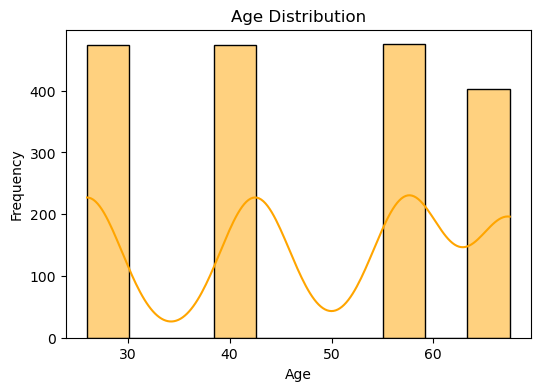

In [274]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Age'], bins=10, kde=True, color='orange')  # You can use any named color or HEX
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#### Count of Hypertension Stages

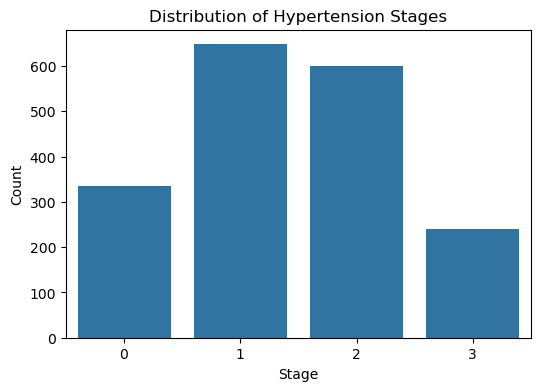

In [275]:
# 3. Count of Each Stage (Bar Chart)
plt.figure(figsize=(6, 4))
sns.countplot(x='Stages', data=df)
plt.title('Distribution of Hypertension Stages')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.show()

#### Gender Distribution (Pie Chart)

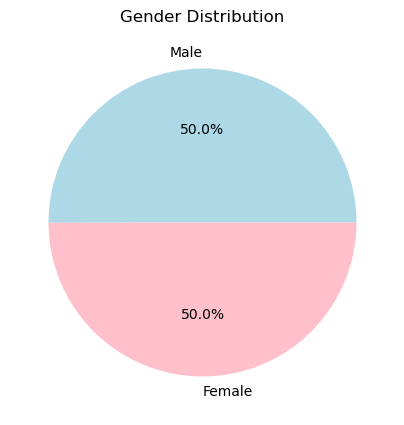

In [276]:
# Mapping back encoded Gender (assuming 0 = Male, 1 = Female)
gender_counts = df['Gender'].value_counts()
labels = ['Male', 'Female']
plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'pink'])
plt.title('Gender Distribution')
plt.show()

#### Systolic Blood Pressure Distribution

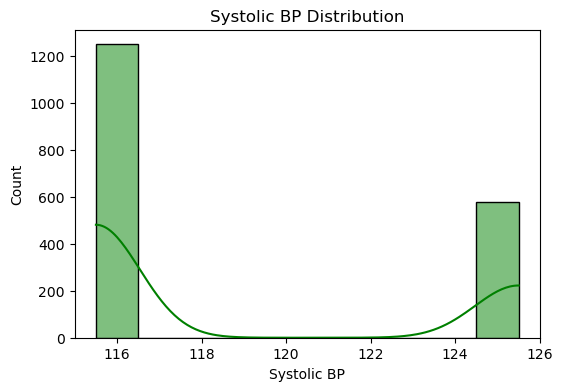

In [277]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Systolic'], bins=10, kde=True, color='green')
plt.title('Systolic BP Distribution')
plt.xlabel('Systolic BP')
plt.ylabel('Count')
plt.show()

### Bivariate Analysis
Bivariate analysis examines relationships between two variables, helping to discover correlations or trends.

#### Systolic vs Diastolic (Scatter Plot by Stage)

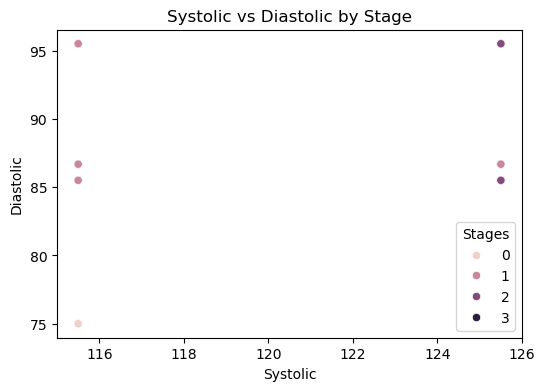

In [278]:
# 2. Systolic vs Diastolic Scatter Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Systolic', y='Diastolic', data=df, hue='Stages')
plt.title('Systolic vs Diastolic by Stage')
plt.show()

#### Medication Adherence vs Severity

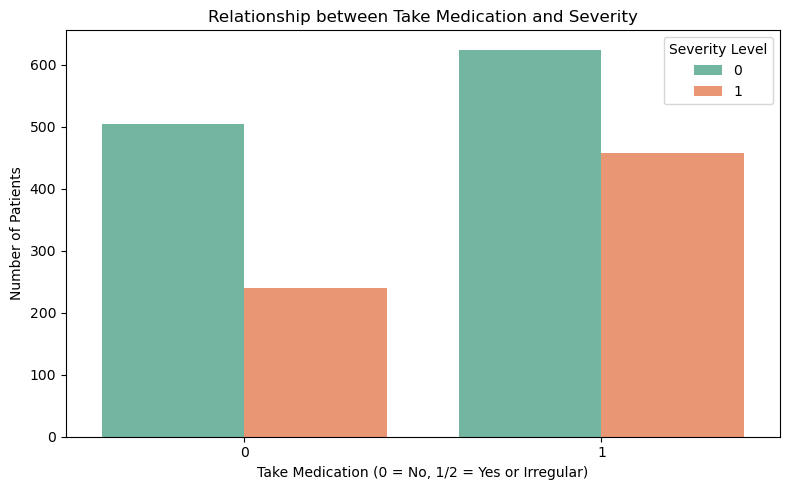

In [279]:

plt.figure(figsize=(8, 5))

# Create a count plot to see interaction between TakeMedication and Severity
sns.countplot(x='TakeMedication', hue='Severity', data=df, palette='Set2')

# Titles and labels
plt.title('Relationship between Take Medication and Severity')
plt.xlabel('Take Medication (0 = No, 1/2 = Yes or Irregular)')
plt.ylabel('Number of Patients')
plt.legend(title='Severity Level')
plt.tight_layout()
plt.show()

### Multivariate Analysis
Multivariate analysis looks at the relationship among more than two features simultaneously.

#### Correlation Heatmap
To analyze overall feature correlation across the dataset

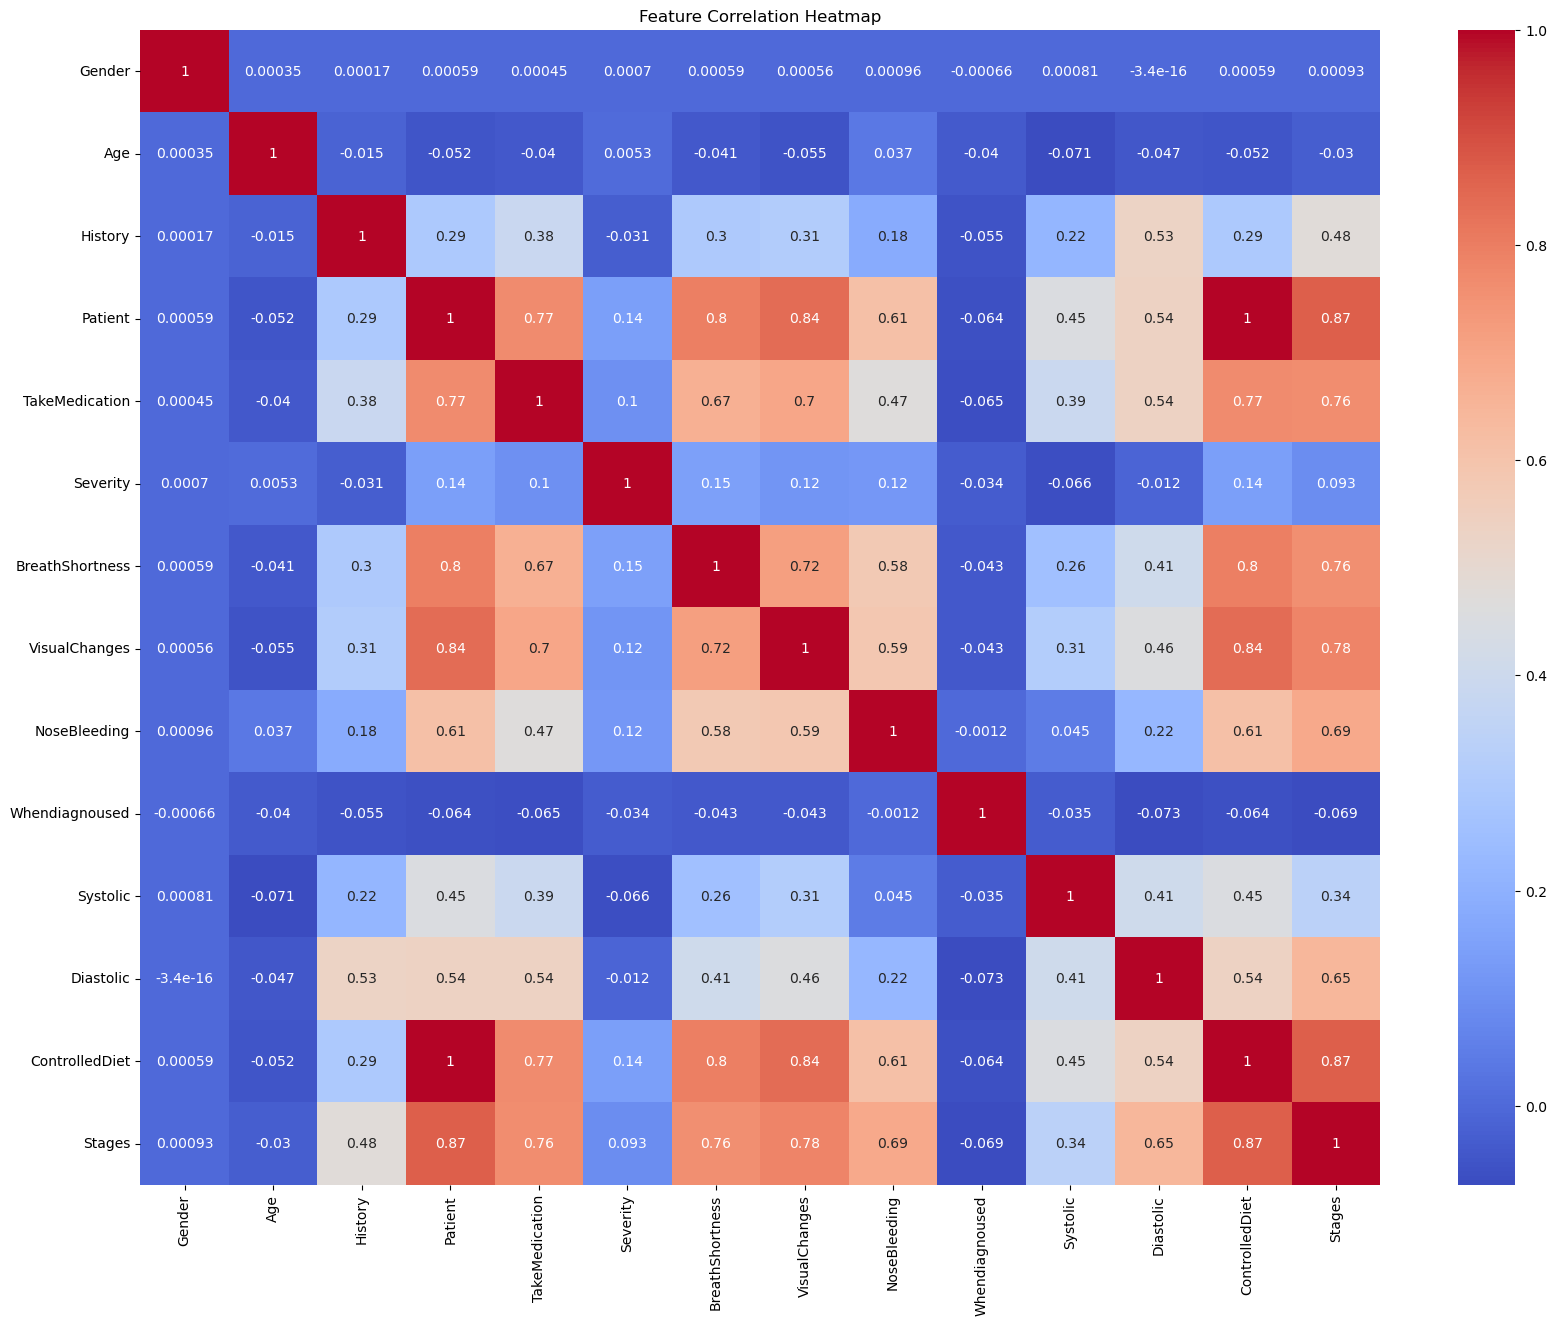

In [280]:
# 4. Heatmap of Correlation
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

#### Pairplot of Key Variables

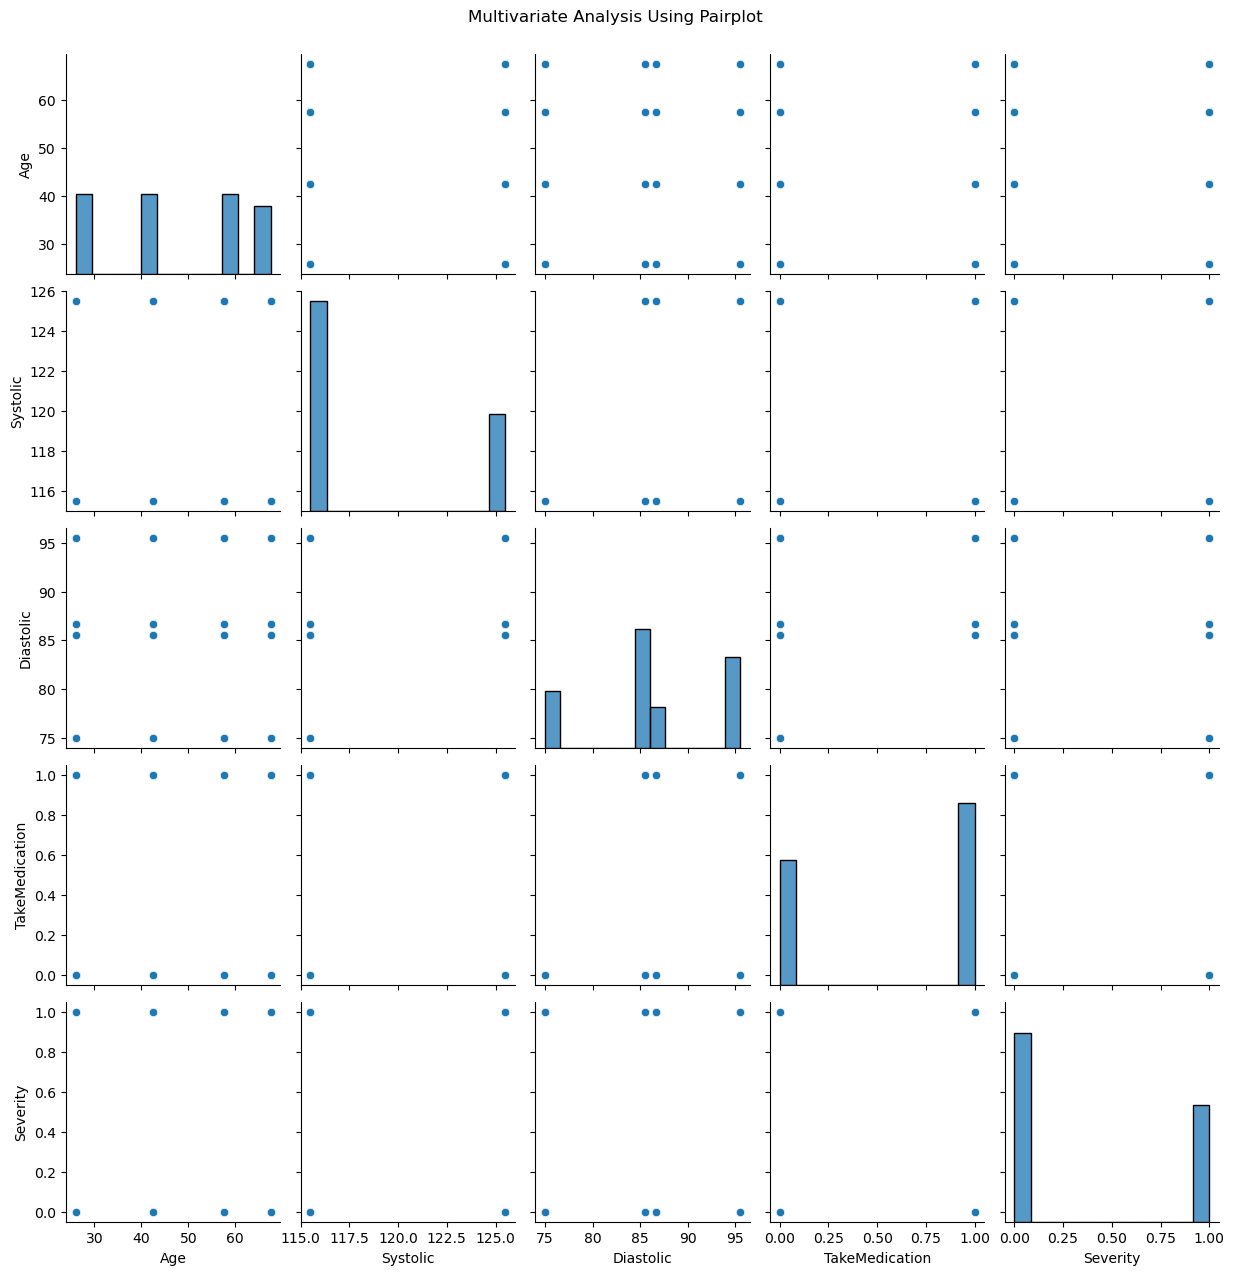

In [281]:
# Updated columns
selected_cols = ['Age', 'Systolic', 'Diastolic', 'TakeMedication', 'Severity']

# Create the pairplot and store the grid object
g = sns.pairplot(df[selected_cols])

# Set the title on the PairGrid
g.fig.suptitle("Multivariate Analysis Using Pairplot", y=1.02)
plt.show()

In [282]:
df.columns

Index(['Gender', 'Age', 'History', 'Patient', 'TakeMedication', 'Severity',
       'BreathShortness', 'VisualChanges', 'NoseBleeding', 'Whendiagnoused',
       'Systolic', 'Diastolic', 'ControlledDiet', 'Stages'],
      dtype='object')

In [283]:
print(df.dtypes)


Gender               int64
Age                float64
History              int64
Patient              int64
TakeMedication       int64
Severity             int64
BreathShortness      int64
VisualChanges        int64
NoseBleeding         int64
Whendiagnoused       int64
Systolic           float64
Diastolic          float64
ControlledDiet       int64
Stages               int64
dtype: object


In [284]:
# Check numeric correlation with target
import pandas as pd

corr = df.corr(numeric_only=True)
print(corr['Stages'].sort_values(ascending=False))


Stages             1.000000
Patient            0.868035
ControlledDiet     0.868035
VisualChanges      0.783683
TakeMedication     0.763496
BreathShortness    0.760220
NoseBleeding       0.688080
Diastolic          0.646658
History            0.479817
Systolic           0.340517
Severity           0.092996
Gender             0.000933
Age               -0.030210
Whendiagnoused    -0.069142
Name: Stages, dtype: float64


In [285]:
print(df.isnull().sum())


Gender             0
Age                0
History            0
Patient            0
TakeMedication     0
Severity           0
BreathShortness    0
VisualChanges      0
NoseBleeding       0
Whendiagnoused     0
Systolic           0
Diastolic          0
ControlledDiet     0
Stages             0
dtype: int64


In [286]:
df.shape

(1825, 14)

In [303]:
# Features & Target
X = df.drop('Stages', axis=1)
y = df['Stages']

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [304]:
# Step 4: Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Step 5: Report
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.915068493150685
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       139
           2       0.86      0.88      0.87       120
           3       0.67      0.63      0.65        46

    accuracy                           0.92       365
   macro avg       0.88      0.88      0.88       365
weighted avg       0.91      0.92      0.91       365



In [305]:
# Step 2: Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("🔹 Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

🔹 Random Forest Accuracy: 0.915068493150685
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       139
           2       0.87      0.88      0.87       120
           3       0.67      0.65      0.66        46

    accuracy                           0.92       365
   macro avg       0.88      0.88      0.88       365
weighted avg       0.91      0.92      0.91       365



In [306]:
# Step 3: Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print("🔹 Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print(classification_report(y_test, dt_pred))

🔹 Decision Tree Accuracy: 0.915068493150685
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       139
           2       0.87      0.88      0.87       120
           3       0.67      0.65      0.66        46

    accuracy                           0.92       365
   macro avg       0.88      0.88      0.88       365
weighted avg       0.91      0.92      0.91       365



In [307]:
# Step 4: Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)

print("🔹 GaussianNB Accuracy:", accuracy_score(y_test, gnb_pred))
print(classification_report(y_test, gnb_pred, zero_division=0))


🔹 GaussianNB Accuracy: 0.8904109589041096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       139
           2       1.00      0.67      0.80       120
           3       0.53      1.00      0.70        46

    accuracy                           0.89       365
   macro avg       0.88      0.92      0.87       365
weighted avg       0.94      0.89      0.90       365



In [308]:
try:
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    mnb_pred = mnb.predict(X_test)
    print("🔹 MultinomialNB Accuracy:", accuracy_score(y_test, mnb_pred))
    print(classification_report(y_test, mnb_pred))
except ValueError as e:
    print("⚠️ MultinomialNB Error:", e)

🔹 MultinomialNB Accuracy: 0.8849315068493151
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        60
           1       0.93      1.00      0.96       139
           2       0.84      0.91      0.88       120
           3       0.70      0.57      0.63        46

    accuracy                           0.88       365
   macro avg       0.87      0.82      0.84       365
weighted avg       0.88      0.88      0.88       365



In [309]:
lr = LogisticRegression(max_iter=1000)

lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],           # Regularization strength
    'penalty': ['l2'],                      # 'l1' works only with solver='liblinear'
    'solver': ['lbfgs', 'liblinear']        # Solver options
}

lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)

print("Best Logistic Regression Params:", lr_grid.best_params_)
print("Best Logistic Regression Accuracy:", lr_grid.best_score_)


Best Logistic Regression Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Logistic Regression Accuracy: 0.9191780821917808


In [310]:
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)
print("Best Random Forest Accuracy:", rf_grid.best_score_)


Best Random Forest Params: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best Random Forest Accuracy: 0.9301369863013699


In [311]:
dt = DecisionTreeClassifier()

dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)

print("Best Decision Tree Params:", dt_grid.best_params_)
print("Best Decision Tree Accuracy:", dt_grid.best_score_)


Best Decision Tree Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
Best Decision Tree Accuracy: 0.9260273972602739


In [312]:
from sklearn.ensemble import RandomForestClassifier

# Trained best model from GridSearchCV
best_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    min_samples_split=10,
    criterion='entropy',
    random_state=42
)

best_rf.fit(X_train, y_train)  # Refit with full training data


RandomForestClassifier(criterion='entropy', min_samples_split=10,
                       n_estimators=50, random_state=42)

In [313]:
import numpy as np

# Example: already encoded new input
# Order of features: ['Gender', 'Age', 'History', 'Patient', 'TakeMedication', 'Severity',
#                     'BreathShortness', 'VisualChanges', 'NoseBleeding', 'Whendiagnoused',
#                     'Systolic', 'Diastolic', 'ControlledDiet']

new_encoded_input = [[
    1,         # Gender (Female)
    52,        # Age
    1,         # History (Yes)
    1,         # Patient (Yes)
    0,         # TakeMedication (No)
    1,         # Severity (Moderate)
    1,         # BreathShortness (Yes)
    0,         # VisualChanges (No)
    1,         # NoseBleeding (Yes)
    2,         # Whendiagnoused (>5 Years)
    160.0,     # Systolic
    100.0,     # Diastolic
    0          # ControlledDiet (No)
]]

# Predict stage
predicted_stage = best_rf.predict(new_encoded_input)[0]

# Optional: reverse mapping (if needed)
inv_stage_map = {
    0: 'NORMAL',
    1: 'ELEVATED',
    2: 'HYPERTENSION (Stage-1)',
    3: 'HYPERTENSION (Stage-2)',
    4: 'HYPERTENSIVE CRISIS'
}

print("Predicted Stage:", inv_stage_map[predicted_stage])


Predicted Stage: HYPERTENSION (Stage-1)


In [314]:
import joblib

# Save the trained Random Forest model
joblib.dump(best_rf, 'random_forest_stage_model.pkl')
print("Model saved successfully as random_forest_stage_model.pkl")


Model saved successfully as random_forest_stage_model.pkl
